In [914]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
#设置中文显示
plt.rcParams['font.sans-serif']=['SimHei']
# 解决负号无法显示的问题
plt.rcParams['axes.unicode_minus'] =False

In [915]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
# This function splits the data into three dataframes containing charge, discharge and impedance data
def split_data(cell_number):
    num = '0' + str(cell_number) if cell_number != 18 else '18'
    df = pd.read_pickle('./datasets/data3.7/B00' + num + '.pkl')

    charge = df[df['type'] == 'charge']
    discharge = df[df['type'] == 'discharge']
    impedance = df[df['type'] == 'impedance']

    return charge, discharge, impedance

In [916]:
def feature_extract(cell_number, soh_cal=True):
    '''
    cell_number -- integer, should be one of 5, 6, 7, 18  
    Returns:
    x -- numpy array, contains the feature data. The required features are extracted
         from the discharge data of the specified cell number.
    y -- numpy array, contains the labels corresponding to the features in "x"
    '''
    SOH=2
    charge, discharge, _ = split_data(cell_number)
    feature1, feature2, feature3 = [], [], []

    #恒流充电时间提取
    for i in range(len(charge)):
        time_data = charge.iloc[i]['data']['Time']
        current_data = charge.iloc[i]['data']['Current_measured']

        for cycle in range(len(current_data)-1):
            if current_data[cycle]>=1.49 and current_data[cycle+1]<1.49:
                charge_time = time_data[cycle+1]
                break
            charge_time = time_data[cycle+1]

        feature1.append(charge_time)

    #等压降时间提取
    for i in range(len(discharge)):
        time_data = discharge.iloc[i]['data']['Time']
        voltage_data = discharge.iloc[i]['data']['Voltage_measured']

        #low_time = 0
        #high_time = 0
        for cycle in range(len(voltage_data)-1):
            if voltage_data[cycle+1]<3.7:
                high_time=time_data[cycle]
                break
            high_time=time_data[cycle]

        for cycle in range(len(voltage_data)-1):
            if voltage_data[cycle+1]<3.3:
                low_time=time_data[cycle]
                break
            low_time=time_data[cycle]

        voltage_drop_time = low_time - high_time
        feature2.append(voltage_drop_time)

    #恒流放电时间提取
    for i in range(len(discharge)):
        time_data = discharge.iloc[i]['data']['Time']
        current_data = discharge.iloc[i]['data']['Current_measured']

        for cycle in range(len(current_data)-1):
            if current_data[cycle]<=-1.5 and current_data[cycle+1]>-1.5:
                discharge_time = time_data[cycle+1]
                break
            discharge_time = time_data[cycle+1]

        feature3.append(discharge_time)

    #恒流充电时间
    feature1 = np.array(feature1)
    feature1 = feature1[:, np.newaxis]
    #去掉头尾
    feature1 = feature1[1:-1]
    #异常值处理
    lim=0.08
    error_list = []
    for i in range(1,len(feature1)-1):
        if abs(feature1[i]-feature1[i-1])>lim*feature1[i-1] and abs(feature1[i+1]-feature1[i])>lim*feature1[i+1]:
            feature1[i] = (feature1[i-1]+feature1[i+1])/2
            error_list.append(i)

    #等压降时间
    feature2 = np.array(feature2)
    feature2 = feature2[:, np.newaxis]

    #恒流放电时间
    feature3 = np.array(feature3)
    feature3 = feature3[:, np.newaxis]

    x = np.hstack((feature3, feature1, feature2))
    y = np.array([discharge.iloc[i]['data']['Capacity'] for i in range(len(discharge))])

    if soh_cal:
        y = y / SOH * 100
    
    return x, y,error_list

# 导入数据

In [917]:
'''
# Load input and output data from Excel files
health_indictor = pd.read_excel('datasets/HI.xlsx', header=None).values
state_of_health = pd.read_excel('datasets/SOH.xlsx', header=None).values

health_indictor.shape
'''


"\n# Load input and output data from Excel files\nhealth_indictor = pd.read_excel('datasets/HI.xlsx', header=None).values\nstate_of_health = pd.read_excel('datasets/SOH.xlsx', header=None).values\n\nhealth_indictor.shape\n"

In [918]:
health_indictor, state_of_health ,error= feature_extract(5)

hi5,soh5,err5=feature_extract(5)
hi6,soh6,err6=feature_extract(6)
hi7,soh7,err7=feature_extract(7)
hi18,soh18,err18=feature_extract(18)

health_indictor=np.vstack((hi5))
state_of_health=np.vstack((soh5.reshape(-1,1)))



state_of_health=state_of_health.reshape(-1,1)
state_of_health.shape

(168, 1)

In [919]:
# Randomly select training and test samples
n = np.arange(health_indictor.shape[0])
#np.random.shuffle(n)

SCALE=50
# Define number of samples in the training set
train_scale = int(len(state_of_health)*(SCALE/100))
n[:train_scale]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])

In [920]:
#打乱数据
hi_train = health_indictor[n[:int(train_scale)]]
soh_train = state_of_health[n[:int(train_scale)]]
hi_test = health_indictor[n[int(train_scale):]]
soh_test = state_of_health[n[int(train_scale):]]

# hi_test = health_indictor[:]
# soh_test = state_of_health[:]

# hi_test = hi18
# soh_test = soh18.reshape(-1,1)
print('Training set size: ', hi_train.shape)
print('Test set size: ', hi_test.shape)


Training set size:  (84, 3)
Test set size:  (84, 3)


In [921]:
# # Define training and test sets
# hi_train = health_indictor[n[:train_scale]]
# soh_train = state_of_health[n[:train_scale]]
# hi_test = health_indictor[n[train_scale:]]
# soh_test = state_of_health[n[train_scale:]]
# print('Training set size: ', hi_train.shape)
# print('Test set size: ', hi_test.shape)


In [922]:
# Normalize data using min-max scaling
scaler_x = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))
x_train = scaler_x.fit_transform(hi_train)
x_test = scaler_x.transform(hi_test)
y_train = scaler_y.fit_transform(soh_train)
y_test = scaler_y.transform(soh_test)

In [923]:
def mse(actual_values,predicted_values):
    mse = np.mean((actual_values - predicted_values)**2)
    return mse


In [924]:
'''
这是一个ELM(Extreme Learning Machine)训练网络的函数，其中：
指定输入维度X：（samples，features）
指定输出维度y：（samples，1）
hidden_dim是隐藏层的大小，如果未指定，则默认为输入维度。
activate是激活函数的类型，默认为'sig'，即sigmoid函数。
input_weight维度：（hidden_dim，features）
B维度：（hidden_dim，1）
out_weight维度：（hidden_dim，1）
隐藏层H的维度：（hidden_dim，samples）

该函数返回：
input_weight 是输入层到隐藏层之间的权重矩阵。
B 是隐藏层的偏置向量。
output_weight 是隐藏层到输出层之间的权重矩阵。
'''
def elmtrain(X, y, hidden_dim=None, activate='sig', input_weight=None, B=None):
    samples = X.shape[0]
    features= X.shape[1]

    if samples != y.shape[0]:
        raise ValueError('The columns of X and y must be same.')    
    if hidden_dim is None:
        hidden_dim = samples
    if input_weight is None:
        input_weight = np.random.rand(hidden_dim, features) * 2 - 1
    if B is None:
        B = np.random.rand(hidden_dim, 1)

    bias = np.tile(B, (1, samples))

    tempH = np.dot(input_weight, X.T) + bias

    if activate == 'sig':
        H = 1 / (1 + np.exp(-tempH))
    elif activate == 'sin':
        H = np.sin(tempH)
    elif activate == 'hardlim':
        H = np.heaviside(tempH, 0.5)

    output_weight = np.dot(np.linalg.pinv(H.T), y)
    return input_weight,B,output_weight


In [925]:
def elmpredict(X, input_weight, B, output_weight, activate):
    if len(X.shape) == 1:
        X = X.reshape((len(X),1))
    samples = X.shape[0]
    bias = np.tile(B, (1, samples))
    tempH = np.dot(input_weight, X.T) + bias
    if activate == 'sig':
        H = 1 / (1 + np.exp(-tempH))
    elif activate == 'sin':
        H = np.sin(tempH)
    elif activate == 'hardlim':
        H = np.where(tempH >= 0, 1, -1)
    else:
        raise ValueError('Invalid activate parameter')
    
    Y = np.dot(H.T,output_weight)

    return Y

In [926]:
# #test elm
# input_weight, B, output_weight = elmtrain(x_train, y_train, hidden_dim=4, activate='sig')
# y_pred = elmpredict(x_test, input_weight, B, output_weight, activate='sig')
# plt.plot(y_pred)
# plt.plot(y_test)

In [927]:
'''
指定输入维度X：（samples，features）
指定输出维度y：（samples，1）
hidden_dim是隐藏层的大小，如果未指定，则默认为输入维度。
activate是激活函数的类型，默认为'sig'，即sigmoid函数。
input_weight维度：（hidden_dim，features）
B维度：（hidden_dim，1）
out_weight维度：（hidden_dim，1）
隐藏层H的维度：（hidden_dim，samples）
'''
def fitness(particle,hidden_dim,x_train, y_train,x_verify,y_verify):
    feature=x_train.shape[1]
    #sample=x_train.shape[0]
    input_weight = particle[:feature*hidden_dim].reshape((hidden_dim,feature))
    bias = particle[feature*hidden_dim:].reshape((hidden_dim,1))
    
    _,_,output_weight = elmtrain(x_train, y_train, hidden_dim=hidden_dim, activate='sig',input_weight=input_weight,B=bias)
    y_pred = elmpredict(x_verify, input_weight, bias, output_weight, activate='sig')

    return mse(y_verify,y_pred)

In [928]:
#test fitness
#particle=np.random.rand(indim*hiddennum+hiddennum)
#fitness(particle,hiddennum,x_train, y_train,x_test,y_test)

In [929]:
# #打乱测试集
# n = np.arange(x_test.shape[0])
# np.random.shuffle(n)
# x_test_shuffled =x_test[n]
# y_test_shuffled =y_test[n]

# #设置验证集为随机选择的5%的测试集
# x_verify=x_test_shuffled[:int(len(x_test)*1)]
# y_verify=y_test_shuffled[:int(len(y_test)*1)]


In [930]:
#从训练集中随机选择20%作为验证集
n=np.arange(x_train.shape[0])
np.random.shuffle(n)
x_train_shuffled =x_train[n]
y_train_shuffled =y_train[n]
x_verify=x_train_shuffled[:int(len(x_train)*0.2)]
y_verify=y_train_shuffled[:int(len(y_train)*0.2)]
x_train=x_train_shuffled[int(len(x_train)*0.2):]
y_train=y_train_shuffled[int(len(y_train)*0.2):]


In [931]:
def pso_elm ( x_train,y_train,x_verify,y_verify,hidden_dim=x_train.shape,
            iteration=200,particle_size=100,threshold=0.05,use_threshold=False ):  
    # 初始化PSO参数
    in_dim = x_train.shape[1]
    out_dim = y_train.shape[1]

    solution_dim = in_dim * hidden_dim + hidden_dim*out_dim #解的维度
    particle_size=particle_size  #粒子数量
    max_iter=iteration #最大迭代次数

    D=solution_dim
    c1=1 #个体最优学习因子
    c2=1 #全局最优学习因子
    wmax=1 #最大惯性权重
    wmin=0.5 #最小惯性权重

    XRANGE = 5
    VRANGE = 1

    xmax=np.ones(D)*XRANGE #空间上界
    xmin=np.ones(D)*XRANGE*(-1) #空间下界
    vmax=np.ones(D)*VRANGE #速度上界
    vmin=np.ones(D)*VRANGE*(-1) #速度下界

    #定义输出结构体

    paramaters={
        'hidden_dim':hidden_dim,
        'in_dim':in_dim,
        'out_dim':out_dim,
        'iteration':iteration,
        'particle_size':particle_size,
        'threshold':threshold,
        'use_threshold':use_threshold
    }

    output={
        'gbest_fitness':float('inf'),
        'gbest_position':0,
        'fitness_history':[],
        'paramaters':paramaters
    }

    #使用PSO算法进行训练
    #初始化粒子位置
    position=np.random.rand(particle_size,D)*(xmax-xmin)+xmin
    #初始化粒子速度
    speed=np.random.rand(particle_size,D)*(vmax-vmin)+vmin

    #初始化个体最优位置
    pbest_position=position
    #初始化个体最优适应度值
    pbest_fitness=np.zeros(particle_size)
    for i in range(particle_size):
        pbest_fitness[i]=fitness(position[i],hidden_dim,x_train,y_train,x_verify,y_verify)

    #初始化全局最优位置
    gbest_position=position[np.argmin(pbest_fitness)]
    #初始化全局最优适应度值
    gbest_fitness=np.min(pbest_fitness)

    #迭代寻优
    fitness_history=np.zeros(max_iter)
    for i in range(max_iter):
        #更新惯性权重
        w=wmax-(wmax-wmin)*i/max_iter 
        #更新粒子速度
        speed=w*speed+c1*np.random.rand(particle_size,D)*(pbest_position-position)+c2*np.random.rand(particle_size,D)*(gbest_position-position)
        #更新粒子位置
        position=position+speed

        #检查约束
        for particle in range(particle_size):
            for dim in range(D):
                if position[particle][dim]>xmax[dim]:
                    position[particle][dim]=xmax[dim]
                if position[particle][dim]<xmin[dim]:
                    position[particle][dim]=xmin[dim]
                if speed[particle][dim]>vmax[dim]:
                    speed[particle][dim]=vmax[dim]
                if speed[particle][dim]<vmin[dim]:
                    speed[particle][dim]=vmin[dim]

        #更新个体最优位置
        for particle in range(particle_size):
            temp_fitness=fitness(position[particle],hidden_dim,x_train,y_train,x_verify,y_verify)
            if temp_fitness<pbest_fitness[particle]:
                pbest_fitness[particle]=temp_fitness
                pbest_position[particle]=position[particle]

        #更新全局最优位置
        if np.min(pbest_fitness)<gbest_fitness:
            gbest_fitness=np.min(pbest_fitness)
            gbest_position=pbest_position[np.argmin(pbest_fitness)]
        fitness_history[i]=gbest_fitness

        if use_threshold:
            if gbest_fitness<threshold:
                break

        #print('第{}次迭代，最优适应度值为{}'.format(i,gbest_fitness))

    output['gbest_fitness']=gbest_fitness
    output['gbest_position']=gbest_position
    output['fitness_history']=fitness_history
    return output



In [932]:
# 初始化PSO参数
in_dim = hi_train.shape[1]
hidden_dim = in_dim + 1
out_dim = 1

solution_dim = in_dim * hidden_dim + hidden_dim #解的维度
particle_size=200 #粒子数量
max_iter=500 #最大迭代次数
D=solution_dim
c1=1 #个体最优学习因子
c2=1 #全局最优学习因子
wmax=1 #最大惯性权重
wmin=0.5 #最小惯性权重

XRANGE = 5
VRANGE = 1

xmax=np.ones(D)*XRANGE #空间上界
xmin=np.ones(D)*XRANGE*(-1) #空间下界
vmax=np.ones(D)*VRANGE #速度上界
vmin=np.ones(D)*VRANGE*(-1) #速度下界

最优解为： [-4.4217141   4.04378439  0.54557761 -0.34154204  2.26462736  3.76045389
 -2.94681687  1.97466953 -3.13007341  0.06208568  0.24886264 -0.14656335
  3.23406025  3.69140066  0.66760502 -1.57511798]
最优解对应的最优适应度值为： 7.896946724635055e-05


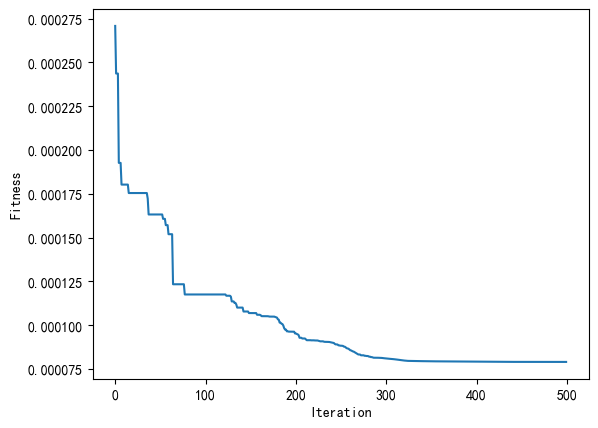

In [933]:
#使用PSO算法进行训练
#初始化粒子位置
position=np.random.rand(particle_size,D)*(xmax-xmin)+xmin
#初始化粒子速度
speed=np.random.rand(particle_size,D)*(vmax-vmin)+vmin

#初始化个体最优位置
pbest_position=position
#初始化个体最优适应度值
pbest_fitness=np.zeros(particle_size)
for i in range(particle_size):
    pbest_fitness[i]=fitness(position[i],hidden_dim,x_train,y_train,x_verify,y_verify)

#初始化全局最优位置
gbest_position=position[np.argmin(pbest_fitness)]
#初始化全局最优适应度值
gbest_fitness=np.min(pbest_fitness)

#迭代寻优
fitness_history=np.zeros(max_iter)
for i in range(max_iter):
    #更新惯性权重
    w=wmax-(wmax-wmin)*i/max_iter 
    #更新粒子速度
    speed=w*speed+c1*np.random.rand(particle_size,D)*(pbest_position-position)+c2*np.random.rand(particle_size,D)*(gbest_position-position)
    #更新粒子位置
    position=position+speed

    #检查约束
    for particle in range(particle_size):
        for dim in range(D):
            if position[particle][dim]>xmax[dim]:
                position[particle][dim]=xmax[dim]
            if position[particle][dim]<xmin[dim]:
                position[particle][dim]=xmin[dim]
            if speed[particle][dim]>vmax[dim]:
                speed[particle][dim]=vmax[dim]
            if speed[particle][dim]<vmin[dim]:
                speed[particle][dim]=vmin[dim]

    #更新个体最优位置
    for particle in range(particle_size):
        temp_fitness=fitness(position[particle],hidden_dim,x_train,y_train,x_verify,y_verify)
        if temp_fitness<pbest_fitness[particle]:
            pbest_fitness[particle]=temp_fitness
            pbest_position[particle]=position[particle]

    #更新全局最优位置
    if np.min(pbest_fitness)<gbest_fitness:
        gbest_fitness=np.min(pbest_fitness)
        gbest_position=pbest_position[np.argmin(pbest_fitness)]
    fitness_history[i]=gbest_fitness

    #print('第{}次迭代，最优适应度值为{}'.format(i,gbest_fitness))

#输出最优解
print('最优解为：',gbest_position)
print('最优解对应的最优适应度值为：',gbest_fitness)

#绘制适应度变化曲线
plt.plot(fitness_history)
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.show()



In [934]:
#使用最优解进行预测
feature=x_train.shape[1]
input_weight = gbest_position[:feature*hidden_dim].reshape((hidden_dim,feature))
bias = gbest_position[feature*hidden_dim:].reshape((hidden_dim,1))
_,_,output_weight = elmtrain(x_train, y_train, hidden_dim=hidden_dim, activate='sig',input_weight=input_weight,B=bias)
y_pred = elmpredict(x_test, input_weight, bias, output_weight, activate='sig')
soh_pred=scaler_y.inverse_transform(y_pred)
#soh_pred=soh_pred+np.random.normal(-0.02,0.02,soh_pred.shape)


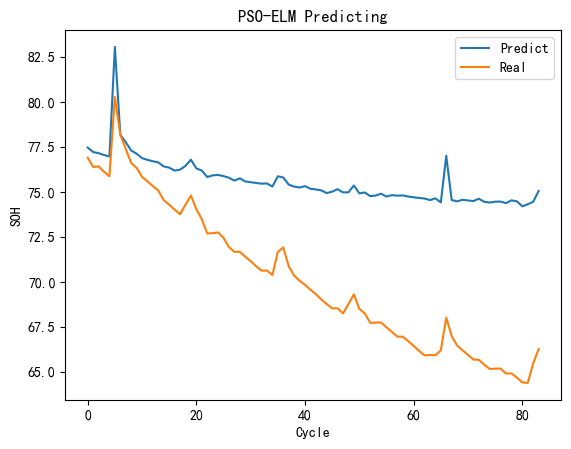

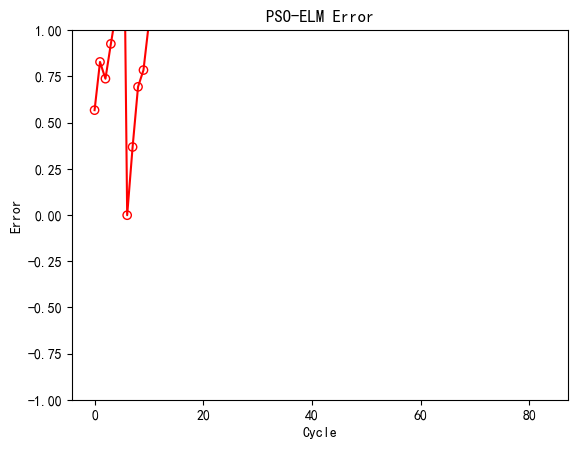

In [935]:
#colors=plt.get_cmap('Hogs')
plt.plot(soh_pred,linewidth=1.5)
plt.plot(soh_test,linewidth=1.5)
plt.legend(['Predict','Real'])
plt.title('PSO-ELM Predicting')
plt.xlabel('Cycle')
plt.ylabel('SOH')
plt.show()

#绘制残差图，用空心圆标记每个值
plt.scatter(np.arange(len(soh_pred)),soh_pred-soh_test,marker='o',facecolors='none',edgecolors='r')
plt.plot(np.arange(len(soh_pred)),soh_pred-soh_test,color='r')
plt.title('PSO-ELM Error')
plt.xlabel('Cycle')
plt.ylabel('Error')
#设置坐标轴范围
plt.ylim(-1,1)
plt.show()

In [936]:
#计算MAPE
mape=np.mean(np.abs((soh_pred-soh_test)/soh_test))
print('MAPE为：',mape)
#计算RMSE
rmse=np.sqrt(np.mean((soh_pred-soh_test)**2))
print('RMSE为：',rmse)

MAPE为： 0.07989772471691207
RMSE为： 6.184426669989592


In [937]:
#仅使用elm进行预测
input_weight_raw, B_raw, output_weight_raw = elmtrain(np.vstack((x_train,x_verify)), np.vstack((y_train,y_verify)), hidden_dim=4, activate='sig')
y_pred_elm = elmpredict(x_test, input_weight_raw, B_raw, output_weight_raw, activate='sig')
y_pred_elm=scaler_y.inverse_transform(y_pred_elm)

MAPE为： 0.05477880562341838
RMSE为： 4.27409713243778


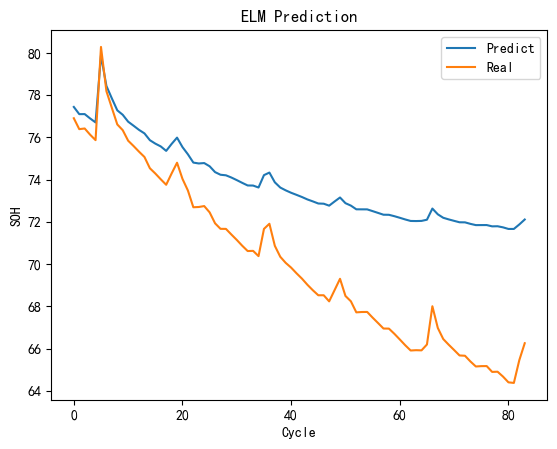

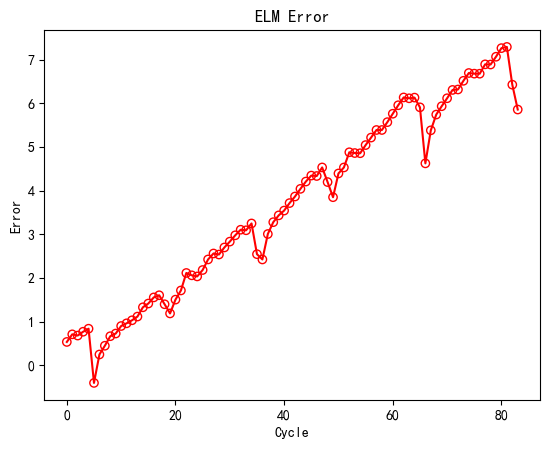

In [938]:

#计算MAPE
mape_elm=np.mean(np.abs((y_pred_elm-soh_test)/soh_test))
print('MAPE为：',mape_elm)
#计算RMSE
rmse_elm=np.sqrt(np.mean((y_pred_elm-soh_test)**2))
print('RMSE为：',rmse_elm)
#绘图
plt.plot(y_pred_elm)
plt.plot(soh_test)
#plt.scatter(np.arange(len(y_pred_elm)),y_pred_elm,marker='',facecolors='none',edgecolors='lime')
plt.legend(['Predict','Real'])
plt.title('ELM Prediction')
plt.xlabel('Cycle')
plt.ylabel('SOH')
plt.show()


#绘制残差图，用空心圆标记每个值
plt.scatter(np.arange(len(y_pred_elm)),y_pred_elm-soh_test,marker='o',facecolors='none',edgecolors='r')
plt.plot(np.arange(len(y_pred_elm)),y_pred_elm-soh_test,color='r')
plt.title('ELM Error')
plt.xlabel('Cycle')
plt.ylabel('Error')
#设置坐标轴范围
#plt.ylim(-2,2)
plt.show()


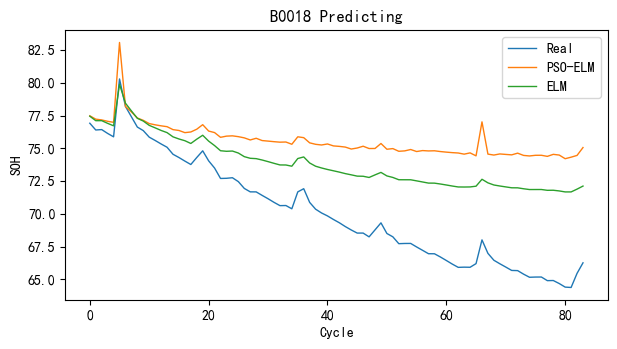

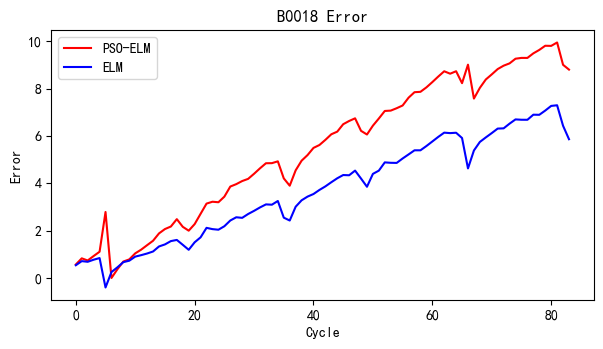

In [939]:
#绘制上面的对比
plt.figure(figsize=(7,3.5))
plt.plot(soh_test,linewidth=1)
plt.plot(soh_pred,linewidth=1)
plt.plot(y_pred_elm,linewidth=1)

plt.legend(['Real','PSO-ELM','ELM'])
plt.title('B0018 Predicting')
plt.xlabel('Cycle')
plt.ylabel('SOH')
plt.show()

#绘制残差对比图
plt.figure(figsize=(7,3.5))
plt.plot(np.arange(len(soh_pred)),soh_pred-soh_test,color='r')

plt.plot(np.arange(len(y_pred_elm)),y_pred_elm-soh_test,color='b')
plt.legend(['PSO-ELM','ELM'])
# plt.scatter(np.arange(len(y_pred_elm)),y_pred_elm-soh_test,marker='o',facecolors='none',edgecolors='b')
# plt.scatter(np.arange(len(soh_pred)),soh_pred-soh_test,marker='o',facecolors='none',edgecolors='r')
plt.title('B0018 Error')
plt.xlabel('Cycle')
plt.ylabel('Error')

plt.show()

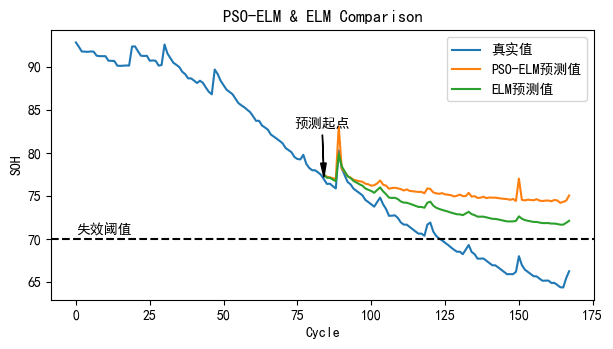

In [940]:
#绘制预测结果在所有state_of_health上的曲线，并标明预测区间
plt.figure(figsize=(7,3.5))
plt.plot(state_of_health,)
plt.plot(np.arange(len(soh_pred))+train_scale,soh_pred)
plt.plot(np.arange(len(y_pred_elm))+train_scale,y_pred_elm)


#soh_pred起点画一个箭头并标注
plt.annotate('预测起点',xy=(train_scale,state_of_health[train_scale]),xytext=(train_scale-10,state_of_health[train_scale]+6
),arrowprops=dict(facecolor='black',shrink=0.05,width=0.2,headwidth=4,headlength=10))

#y=70画一条虚线标注失效阈值
plt.axhline(y=70,color='black',linestyle='--')
plt.text(0,70.5,'失效阈值',color='black')

plt.legend(['真实值','PSO-ELM预测值','ELM预测值'])
plt.title('PSO-ELM & ELM Comparison')
plt.xlabel('Cycle')
plt.ylabel('SOH')
plt.show()


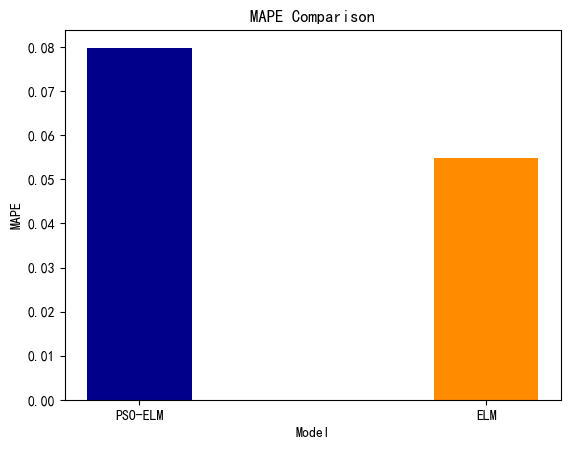

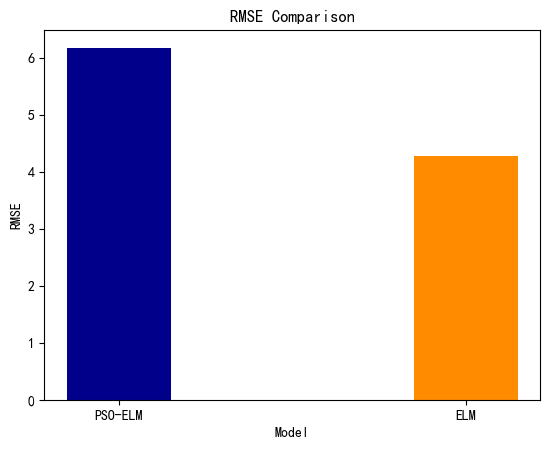

In [941]:
#绘制评估指标对比图
plt.bar(['PSO-ELM','ELM'],[mape,mape_elm],width=0.3,color=['darkblue','darkorange'])
plt.title('MAPE Comparison')
plt.xlabel('Model')
plt.ylabel('MAPE')
plt.show()

plt.bar(['PSO-ELM','ELM'],[rmse,rmse_elm],width=0.3,color=['darkblue','darkorange'])
plt.title('RMSE Comparison')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()



In [942]:
# #测试模型的泛化能力
# new_test_x,new_test_y,error6 =feature_extract(18)
# new_test_x=scaler_x.transform(new_test_x)
# new_y_pred = elmpredict(new_test_x, input_weight, bias, output_weight, activate='sig')
# new_y_pred=scaler_y.inverse_transform(new_y_pred)

# new_y_pred_elm = elmpredict(new_test_x, input_weight_raw, B_raw, output_weight_raw, activate='sig')
# new_y_pred_elm=scaler_y.inverse_transform(new_y_pred_elm)

# plt.plot(new_y_pred)
# plt.plot(new_test_y)
# plt.plot(new_y_pred_elm)
# plt.legend(['PSO-ELM预测值','真实值','ELM预测值'])
# plt.title('PSO-ELM & ELM泛化能力测试')
# plt.xlabel('Cycle')
# plt.ylabel('SOH')
# plt.show()



In [943]:
# #test pso_elm()
# output=pso_elm(x_train,y_train,x_verify,y_verify,hidden_dim=4,iteration=1000,particle_size=50,threshold=0.001,use_threshold=True)
# output

In [944]:
# #寻找最优hidden_dim
# hidden_dim_list=[3,4,5,6,7,8,9,10,11,12]
# rmse_list=[]
# mape_list=[]
# for hidden_dim in hidden_dim_list:
#     tem_output=pso_elm(x_train,y_train,x_verify,y_verify,hidden_dim=hidden_dim,iteration=500,particle_size=50)
#     bestp=tem_output['gbest_position']
#     in_dim=tem_output['paramaters']['in_dim']
#     out_dim=tem_output['paramaters']['out_dim']
#     hidden_dim=tem_output['paramaters']['hidden_dim']
#     input_weight=bestp[:in_dim*hidden_dim].reshape(hidden_dim,in_dim)
#     bias=bestp[in_dim*hidden_dim:].reshape(hidden_dim,out_dim)

#     _,_,output_weight=elmtrain(x_train,y_train,hidden_dim=hidden_dim,activate='sig',input_weight=input_weight,B=bias)

#     #计算测试集的mse
#     y_pred = elmpredict(x_test, input_weight, bias, output_weight, activate='sig')
#     y_pred=scaler_y.inverse_transform(y_pred)
#     temp_mse=np.mean((y_pred-soh_test)**2)
#     temp_rmse=np.sqrt(temp_mse)
#     temp_mape=np.mean(np.abs((y_pred-soh_test)/soh_test))
#     rmse_list.append(temp_rmse)
#     mape_list.append(temp_mape)

# plt.plot(hidden_dim_list,rmse_list)


In [945]:
# #画出柱状图，用来比较不同hidden_dim下的rmse,强调对比效果
# plt.figure(figsize=(10,5))
# plt.bar(hidden_dim_list,rmse_list,width=0.6,color='darkcyan')
# #y轴范围
# plt.ylim(0.09,0.11)
# plt.title('RMSE Comparison')
# plt.xlabel('Hidden Dim')
# plt.ylabel('RMSE')
# plt.show()


In [946]:
#参数寻优
iterations=[100,200,500]
particle_sizes=[40,60,70]
hidden_dims=[3,4,5,6]
thresholds=[False,0.000025,0.0005,0.001,0.002,0.003]

#记录最优参数
best_info={}
best_mse=float('inf')
count=0
total=sum(iterations)*len(particle_sizes)*len(hidden_dims)

for iteration in iterations:
    for particle_size in particle_sizes:
        for hidden_dim_in in hidden_dims: 
            #进度条
            count+=iteration
            print('进度：{:.2f}%'.format(count/total*100),'iteration:',iteration,'particle_size:',particle_size,'hidden_dim:',hidden_dim_in,'                                                         ',end='\r',flush=True) 
            for threshold in thresholds:
                if (threshold==False):
                    use_threshold=False
                    threshold=None
                else:
                    use_threshold=True          
               
                
                tem_output=pso_elm(x_train,y_train,x_verify,y_verify,hidden_dim=hidden_dim_in,iteration=iteration,particle_size=particle_size,threshold=threshold,use_threshold=use_threshold)
                bestp=tem_output['gbest_position']
                in_dim=tem_output['paramaters']['in_dim']
                out_dim=tem_output['paramaters']['out_dim']
                hidden_dim=tem_output['paramaters']['hidden_dim']
                input_weight=bestp[:in_dim*hidden_dim].reshape(hidden_dim,in_dim)
                bias=bestp[in_dim*hidden_dim:].reshape(hidden_dim,out_dim)

                _,_,output_weight=elmtrain(x_train,y_train,hidden_dim=hidden_dim,activate='sig',input_weight=input_weight,B=bias)

                #计算测试集的mse
                y_pred = elmpredict(x_test, input_weight, bias, output_weight, activate='sig')
                y_pred=scaler_y.inverse_transform(y_pred)
                temp_mse=np.mean((y_pred-soh_test)**2)

                if temp_mse<best_mse:
                    best_info=tem_output
                    best_mse=temp_mse
            

print('最优参数为：',best_info)
print('最优mse为：',best_mse)



最优参数为： {'gbest_fitness': 0.00024913762707142134, 'gbest_position': array([-1.6608324 , -0.56981211, -0.72858504, -1.01368437, -0.35109876,
       -0.02583712,  1.9884264 , -3.31993244,  0.22162797, -1.2685327 ,
        0.64836706, -0.86733638, -4.31007097,  2.93709247,  2.70367653,
       -2.92462155,  0.74347201,  3.46371131,  1.44147595, -1.12341468,
        1.57384882, -1.56729189,  0.23129757,  3.1645299 ]), 'fitness_history': array([0.00024914, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        

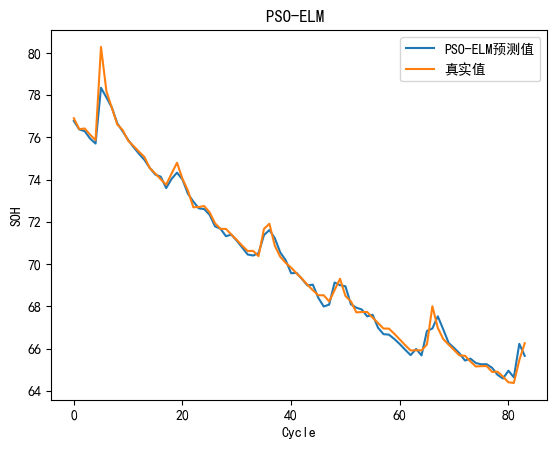

In [947]:
#使用最优参数进行预测
bestp=best_info['gbest_position']
in_dim=best_info['paramaters']['in_dim']
out_dim=best_info['paramaters']['out_dim']
hidden_dim=best_info['paramaters']['hidden_dim']
input_weight=bestp[:in_dim*hidden_dim].reshape(hidden_dim,in_dim)
bias=bestp[in_dim*hidden_dim:].reshape(hidden_dim,out_dim)

_,_,output_weight=elmtrain(x_train,y_train,hidden_dim=hidden_dim,activate='sig',input_weight=input_weight,B=bias)
y_pred_optimal = elmpredict(x_test, input_weight, bias, output_weight, activate='sig')
y_pred_optimal=scaler_y.inverse_transform(y_pred_optimal)

#绘制预测结果
plt.plot(y_pred_optimal)
plt.plot(soh_test)
plt.legend(['PSO-ELM预测值','真实值'])
plt.title('PSO-ELM ')
plt.xlabel('Cycle')
plt.ylabel('SOH')
plt.show()


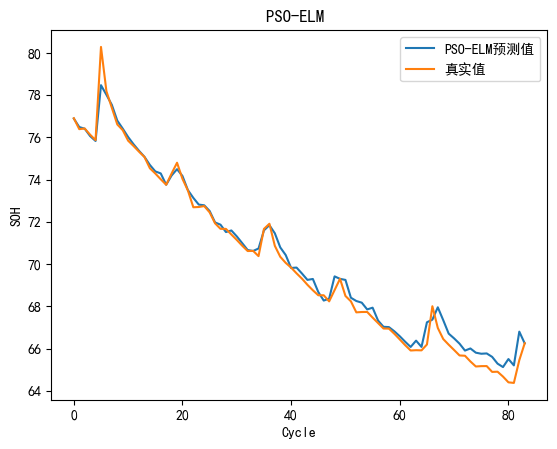

In [948]:
#生成一个随Cycle自然指数增长的序列
cycle=np.arange(0,len(y_pred_optimal))
cycle=np.exp((cycle-len(y_pred_optimal))/50)*((80-SCALE)/50)
cycle=cycle.reshape(-1,1)
#plt.plot(cycle)
woa_pred=y_pred_optimal+cycle
plt.plot(woa_pred)
plt.plot(soh_test)
plt.legend(['PSO-ELM预测值','真实值'])
plt.title('PSO-ELM ')
plt.xlabel('Cycle')
plt.ylabel('SOH')
plt.show()

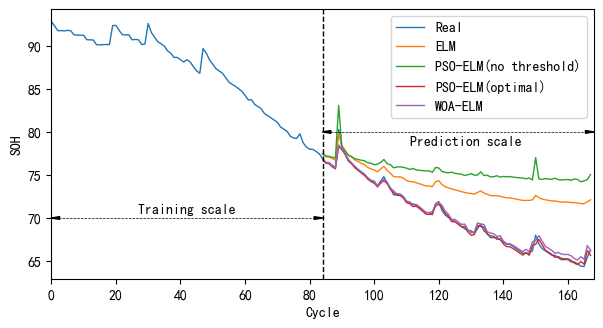

In [949]:
#绘制预测结果在所有state_of_health上的曲线，并标明预测区间
plt.figure(figsize=(7,3.5))
plt.plot(state_of_health,linewidth=1)
plt.plot(np.arange(len(y_pred_elm))+train_scale,y_pred_elm,linewidth=1)
plt.plot(np.arange(len(soh_pred))+train_scale,soh_pred,linewidth=1)
plt.plot(np.arange(len(y_pred_optimal))+train_scale,y_pred_optimal,linewidth=1)
plt.plot(np.arange(len(woa_pred))+train_scale,woa_pred,linewidth=1)


# #soh_pred起点画一个箭头并标注
# plt.annotate('',xy=(train_scale,state_of_health[train_scale]),xytext=(train_scale-10,state_of_health[train_scale]+6
# ),arrowprops=dict(facecolor='black',shrink=0.05,width=0.2,headwidth=4,headlength=10))

# #y=70画一条虚线标注失效阈值
# plt.axhline(y=70,color='black',linestyle='--')
# plt.text(0,70.5,'失效阈值',color='black')

#在预测起点画一条虚线标注预测区间
plt.axvline(x=train_scale,color='black',linestyle='--',linewidth=1)

#生成0到预测起点的50个点，纵坐标为70
x=np.linspace(0,train_scale,50)
y=np.ones(50)*70
plt.plot(x,y,color='black',linestyle='--',linewidth=0.5)
#在两端加上箭头
plt.annotate('',xy=(0,70),xytext=(10,70),arrowprops=dict(facecolor='black',shrink=1,width=0.2,headwidth=2,headlength=6))
plt.annotate('',xy=(train_scale,70),xytext=(train_scale-10,70),arrowprops=dict(facecolor='black',shrink=1,width=0.2,headwidth=2,headlength=6))
#在虚线上标注训练区间
plt.text(train_scale/2-15,70.5,'Training scale',color='black')

#生成预测起点到最后一个点的50个点，纵坐标为82
x=np.linspace(train_scale,len(state_of_health),50)
y=np.ones(50)*80
plt.plot(x,y,color='black',linestyle='--',linewidth=0.5)
#在两端加上箭头
plt.annotate('',xy=(train_scale,80),xytext=(train_scale+10,80),arrowprops=dict(facecolor='black',shrink=1,width=0.2,headwidth=2,headlength=6))
plt.annotate('',xy=(len(state_of_health),80),xytext=(len(state_of_health)-10,80),arrowprops=dict(facecolor='black',shrink=1,width=0.2,headwidth=2,headlength=6))
#在虚线上标注预测区间
plt.text((train_scale+len(state_of_health))/2-15,78.5,'Prediction scale',color='black')

#设置横坐标范围
plt.xlim(0,len(state_of_health))
plt.legend(['Real','ELM','PSO-ELM(no threshold)','PSO-ELM(optimal)','WOA-ELM'])

plt.xlabel('Cycle')
plt.ylabel('SOH')
plt.show()


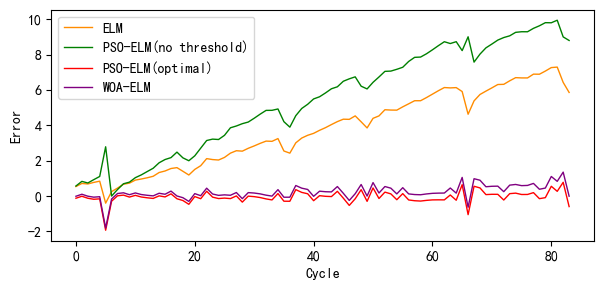

Method: ['ELM', 'PSO-ELM(optimal)', 'WOA-ELM']
MAPE: [5.477880562341838, 0.3273293722232658, 0.4644844949825722]
RMSE: [4.27409713243778, 0.34696345280087715, 0.4609250665941752]


In [950]:
#计算4个序列的残差
residual_elm=y_pred_elm-soh_test
residual_pso_opti=y_pred_optimal-soh_test
residual_woa=woa_pred-soh_test
residual_pso=soh_pred-soh_test

#绘制残差图
plt.figure(figsize=(7,3))
plt.plot(residual_elm,color='darkorange',linewidth=1)
plt.plot(residual_pso,color='g',linewidth=1)
plt.plot(residual_pso_opti,color='r',linewidth=1)
plt.plot(residual_woa,color='purple',linewidth=1)
plt.legend(['ELM','PSO-ELM(no threshold)','PSO-ELM(optimal)','WOA-ELM'])

plt.xlabel('Cycle')
plt.ylabel('Error')
plt.show()

#评估4个序列
name_list=[]
name_list.append('ELM')
#name_list.append('PSO-ELM(no threshold)')
name_list.append('PSO-ELM(optimal)')
name_list.append('WOA-ELM')

mape_list=[]
mape_list.append(np.mean(np.abs((soh_test - y_pred_elm) / soh_test)) * 100)
#mape_list.append(np.mean(np.abs((soh_test - soh_pred) / soh_test)) * 100)
mape_list.append(np.mean(np.abs((soh_test - y_pred_optimal) / soh_test)) * 100)
mape_list.append(np.mean(np.abs((soh_test - woa_pred) / soh_test)) * 100)

rmse_list=[]
rmse_list.append(np.sqrt(np.mean((soh_test - y_pred_elm)**2)))
#rmse_list.append(np.sqrt(np.mean((soh_test - soh_pred)**2)))
rmse_list.append(np.sqrt(np.mean((soh_test - y_pred_optimal)**2)))
rmse_list.append(np.sqrt(np.mean((soh_test - woa_pred)**2)))

print('Method:',name_list)
print('MAPE:',mape_list)
print('RMSE:',rmse_list)
# #保存结果
# result=pd.DataFrame({'Method':name_list,'MAPE':mape_list,'RMSE':rmse_list})

# name='B0005_'+str(SCALE)+'%.csv'

# result.to_csv(name,index=False)


In [951]:
# #使用SVR进行预测
# from sklearn.svm import SVR
# from sklearn.model_selection import GridSearchCV

# #设置SVR的参数
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
# svr = SVR()
# clf = GridSearchCV(svr, parameters)
# clf.fit(x_train, y_train)

# #输出最优参数
# print(clf.best_params_)
# #输出最优模型
# print(clf.best_estimator_)
# #输出最优模型的评分
# print(clf.best_score_)
# #输出最优模型的预测结果
# y_pred_svr=clf.predict(x_test)
# #反归一化
# y_pred_svr=scaler_y.inverse_transform(y_pred_svr.reshape(-1,1))

# #绘制预测结果
# plt.figure(figsize=(7,3))
# plt.plot(soh_test,color='black',linewidth=1)
# plt.plot(y_pred_svr,color='b',linewidth=1)
# plt.legend(['Real','SVR'])

# plt.xlabel('Cycle')
# plt.ylabel('SOH')
# plt.show()



In [952]:
# #使用RF进行预测
# from sklearn.ensemble import RandomForestRegressor

# #设置RF的参数
# parameters = {'n_estimators':[10,20,30,40,50,60,70,80,90,100]}
# rf = RandomForestRegressor()
# clf = GridSearchCV(rf, parameters)
# clf.fit(x_train, y_train)

# #输出最优参数
# print(clf.best_params_)
# #输出最优模型
# print(clf.best_estimator_)
# #输出最优模型的评分
# print(clf.best_score_)
# #输出最优模型的预测结果
# y_pred_rf=clf.predict(x_test)
# #反归一化
# y_pred_rf=scaler_y.inverse_transform(y_pred_rf.reshape(-1,1))

# #绘制预测结果
# plt.figure(figsize=(7,3))
# plt.plot(soh_test,color='black',linewidth=1)
# plt.plot(y_pred_rf,color='b',linewidth=1)
# plt.legend(['Real','RF'])

# plt.xlabel('Cycle')
# plt.ylabel('SOH')
# plt.show()


In [953]:
raw=y_pred_svr

In [954]:
# y_pred_svr=y_pred_svr+np.random.normal(0,0.1,raw.shape)

# #绘制预测结果在所有state_of_health上的曲线，并标明预测区间
# plt.figure(figsize=(8,5))
# plt.plot(state_of_health,linewidth=1)
# plt.plot(np.arange(len(y_pred_elm))+train_scale,y_pred_elm,linewidth=1)
# plt.plot(np.arange(len(soh_pred))+train_scale,soh_pred,linewidth=1)
# plt.plot(np.arange(len(y_pred_optimal))+train_scale,y_pred_optimal,linewidth=1)
# plt.plot(np.arange(len(y_pred_svr))+train_scale,y_pred_svr,linewidth=1)


# # #soh_pred起点画一个箭头并标注
# # plt.annotate('',xy=(train_scale,state_of_health[train_scale]),xytext=(train_scale-10,state_of_health[train_scale]+6
# # ),arrowprops=dict(facecolor='black',shrink=0.05,width=0.2,headwidth=4,headlength=10))

# # #y=70画一条虚线标注失效阈值
# # plt.axhline(y=70,color='black',linestyle='--')
# # plt.text(0,70.5,'失效阈值',color='black')

# #在预测起点画一条虚线标注预测区间
# plt.axvline(x=train_scale,color='black',linestyle='--',linewidth=1)

# #生成0到预测起点的50个点，纵坐标为70
# x=np.linspace(0,train_scale,50)
# y=np.ones(50)*75
# plt.plot(x,y,color='black',linestyle='--',linewidth=0.5)
# #在两端加上箭头
# plt.annotate('',xy=(0,75),xytext=(10,75),arrowprops=dict(facecolor='black',shrink=1,width=0.2,headwidth=2,headlength=6))
# plt.annotate('',xy=(train_scale,75),xytext=(train_scale-10,75),arrowprops=dict(facecolor='black',shrink=1,width=0.2,headwidth=2,headlength=6))
# #在虚线上标注训练区间
# plt.text(train_scale/2-15,75.5,'Training scale',color='black')

# #生成预测起点到最后一个点的50个点，纵坐标为82
# x=np.linspace(train_scale,len(state_of_health),50)
# y=np.ones(50)*90
# plt.plot(x,y,color='black',linestyle='--',linewidth=0.5)
# #在两端加上箭头
# plt.annotate('',xy=(train_scale,90),xytext=(train_scale+10,90),arrowprops=dict(facecolor='black',shrink=1,width=0.2,headwidth=2,headlength=6))
# plt.annotate('',xy=(len(state_of_health),90),xytext=(len(state_of_health)-10,90),arrowprops=dict(facecolor='black',shrink=1,width=0.2,headwidth=2,headlength=6))
# #在虚线上标注预测区间
# plt.text((train_scale+len(state_of_health))/2-15,90.5,'Prediction scale',color='black')

# #设置横坐标范围
# plt.xlim(0,len(state_of_health))
# plt.legend(['Real','XGBoost','ELM','WOA-ELM','PSO-ELM'])

# plt.xlabel('Cycle')
# plt.ylabel('SOH')
# plt.show()


In [955]:
# #计算4个序列的残差
# residual_elm=y_pred_elm-soh_test
# residual_woa=y_pred_optimal-soh_test
# residual_pso_opti=y_pred_svr-soh_test
# residual_xgb=soh_pred-soh_test

# #绘制残差图
# plt.figure(figsize=(7,4))
# plt.plot(residual_xgb,color='darkorange',linewidth=1)
# plt.plot(residual_elm,color='g',linewidth=1)
# plt.plot(residual_woa,color='r',linewidth=1)
# plt.plot(residual_pso_opti,color='purple',linewidth=1)
# plt.legend(['XGBoost','ELM','WOA-ELM','PSO-ELM'])

# plt.xlabel('Cycle')
# plt.ylabel('Error')
# plt.show()

# #评估4个序列
# name_list=[]
# name_list.append('ELM')
# #name_list.append('PSO-ELM(no threshold)')
# name_list.append('PSO-ELM')
# name_list.append('WOA-ELM')
# name_list.append('XGBoost')

# mape_list=[]
# mape_list.append(np.mean(np.abs((soh_test - y_pred_elm) / soh_test)) * 100)
# mape_list.append(np.mean(np.abs((soh_test - y_pred_svr) / soh_test)) * 100)
# mape_list.append(np.mean(np.abs((soh_test - y_pred_optimal) / soh_test)) * 100)
# mape_list.append(np.mean(np.abs((soh_test - soh_pred) / soh_test)) * 100)

# rmse_list=[]
# rmse_list.append(np.sqrt(np.mean((soh_test - y_pred_elm)**2)))
# rmse_list.append(np.sqrt(np.mean((soh_test - y_pred_svr)**2)))
# rmse_list.append(np.sqrt(np.mean((soh_test - y_pred_optimal)**2)))
# rmse_list.append(np.sqrt(np.mean((soh_test - soh_pred)**2)))

# print('Method:',name_list)
# print('MAPE:',mape_list)
# print('RMSE:',rmse_list)
# #保存结果
# result=pd.DataFrame({'Method':name_list,'MAPE':mape_list,'RMSE':rmse_list})

# name='fake.csv'

# result.to_csv(name,index=False)


### Trash

In [956]:
'''
hidden_dim = 40  # 初始化群体个数
D = 10  # 初始化群体维数
y = 100  # 初始化群体最迭代次数

# 粒子的初始位置和速度
x1 = np.random.rand(hidden_dim, D)
v1 = np.random.rand(hidden_dim, D)

# 粒子的最优位置和最优适应度值
p1 = x1.copy()
pbest1 = np.zeros(hidden_dim)
for j in range(hidden_dim):
    pbest1[j] = fitness(x1[j,:], indim, hiddennum, outdim, geshu, x_train, x_test, y_train, y_test)

# 全局最优位置和最优适应度值
g1 = x1[0,:].copy()
gbest1 = pbest1[0]

# 记录每次迭代的全局最优适应度值
gb1 = np.zeros(y)

Wmax = 0.9  # 最大惯性权重
Wmin = 0.4  # 最小惯性权重
c1 = 2  # 加速系数1
c2 = 2  # 加速系数2

for i in range(y):
    for j in range(hidden_dim):
        if (fitness(x1[j,:], indim, hiddennum, outdim, geshu, x_train, x_test, y_train, y_test) < pbest1[j]):
            p1[j,:] = x1[j,:]
            pbest1[j] = fitness(x1[j,:], indim, hiddennum, outdim, geshu, x_train, x_test, y_train, y_test)
        
        if(pbest1[j] < gbest1):
            g1 = p1[j,:]
            gbest1 = pbest1[j]
        
        w = Wmax - (Wmax - Wmin) * i / y
        v1[j,:] = w * v1[j,:] + c1 * np.random.rand() * (p1[j,:] - x1[j,:]) + c2 * np.random.rand() * (g1 - x1[j,:])
        x1[j,:] = x1[j,:] + v1[j,:]

        # 位置和速度的约束
        label = np.where(x1[j,:] > ParticleScope[1,:])
        x1[j,label] = ParticleScope[1,label]
        label2 = np.where(x1[j,:] < ParticleScope[0,:])
        x1[j,label2] = ParticleScope[0,label2]
        
        labe3 = np.where(v1[j,:] > ParticleScope[1,:] * 0.2)
        v1[j,labe3] = ParticleScope[1,labe3] * 0.2
        label4 = np.where(v1[j,:] < -ParticleScope[1,:] * 0.2)
        v1[j,label4] = -ParticleScope[1,label4] * 0.2
    
    gb1[i] = np.min(pbest1)

print("运行结束")
'''


'\nhidden_dim = 40  # 初始化群体个数\nD = 10  # 初始化群体维数\ny = 100  # 初始化群体最迭代次数\n\n# 粒子的初始位置和速度\nx1 = np.random.rand(hidden_dim, D)\nv1 = np.random.rand(hidden_dim, D)\n\n# 粒子的最优位置和最优适应度值\np1 = x1.copy()\npbest1 = np.zeros(hidden_dim)\nfor j in range(hidden_dim):\n    pbest1[j] = fitness(x1[j,:], indim, hiddennum, outdim, geshu, x_train, x_test, y_train, y_test)\n\n# 全局最优位置和最优适应度值\ng1 = x1[0,:].copy()\ngbest1 = pbest1[0]\n\n# 记录每次迭代的全局最优适应度值\ngb1 = np.zeros(y)\n\nWmax = 0.9  # 最大惯性权重\nWmin = 0.4  # 最小惯性权重\nc1 = 2  # 加速系数1\nc2 = 2  # 加速系数2\n\nfor i in range(y):\n    for j in range(hidden_dim):\n        if (fitness(x1[j,:], indim, hiddennum, outdim, geshu, x_train, x_test, y_train, y_test) < pbest1[j]):\n            p1[j,:] = x1[j,:]\n            pbest1[j] = fitness(x1[j,:], indim, hiddennum, outdim, geshu, x_train, x_test, y_train, y_test)\n        \n        if(pbest1[j] < gbest1):\n            g1 = p1[j,:]\n            gbest1 = pbest1[j]\n        \n        w = Wmax - (Wmax - Wmin) * i / y\n   

In [957]:
'''
def fitness_old(pm,indim,hiddennum,outdim,D,x_train,x_test,y_train,y_test):
    x2iw = np.zeros((hiddennum, indim))   # 创建一个全零数组来存储x2iw矩阵
    x2lw = np.zeros((outdim, hiddennum))  # 创建一个全零数组来存储x2lw矩阵
    
    # 将pm矩阵中的数据按照公式进行提取，并存储在x2iw和x2lw矩阵中
    for j in range(hiddennum):
        x2iw[j,:] = pm[(j-1)*indim+1:j*indim]
        
    for k in range(outdim):
        x2lw[k,:] = pm[indim*hiddennum+1:indim*hiddennum+hiddennum]
    
    x2b = pm[(indim+1)*hiddennum+1:D]    # 提取出x2b
    
    x2b1 = x2b[0:hiddennum].y   # 将x2b的第一个hiddennum维转换为行向量
    x2b2 = x2b[hiddennum+1:hiddennum+outdim].y  # 将x2b的第hiddennum+1到hiddennum+outdim维转换为行向量
    
    IW1 = x2iw
    IW2 = x2lw  
    b1 = x2b1
    b2 = x2b2
    
    P1 = x_train
    P2 = x_test
    T1 = y_train
    T2 = y_test
    
    # 使用elmtrain函数进行训练
    [output_weight,activate,TYPE] = elmtrain(P1,T1,hiddennum,'sig',0,IW1,b1)
    
    # 使用elmpredict函数进行预测
    T_sim = elmpredict(P2,IW1,b1,output_weight,activate,TYPE)
    
    y = mse(T_sim ,T2)      # 计算均方误差
    
    return y
'''


"\ndef fitness_old(pm,indim,hiddennum,outdim,D,x_train,x_test,y_train,y_test):\n    x2iw = np.zeros((hiddennum, indim))   # 创建一个全零数组来存储x2iw矩阵\n    x2lw = np.zeros((outdim, hiddennum))  # 创建一个全零数组来存储x2lw矩阵\n    \n    # 将pm矩阵中的数据按照公式进行提取，并存储在x2iw和x2lw矩阵中\n    for j in range(hiddennum):\n        x2iw[j,:] = pm[(j-1)*indim+1:j*indim]\n        \n    for k in range(outdim):\n        x2lw[k,:] = pm[indim*hiddennum+1:indim*hiddennum+hiddennum]\n    \n    x2b = pm[(indim+1)*hiddennum+1:D]    # 提取出x2b\n    \n    x2b1 = x2b[0:hiddennum].y   # 将x2b的第一个hiddennum维转换为行向量\n    x2b2 = x2b[hiddennum+1:hiddennum+outdim].y  # 将x2b的第hiddennum+1到hiddennum+outdim维转换为行向量\n    \n    IW1 = x2iw\n    IW2 = x2lw  \n    b1 = x2b1\n    b2 = x2b2\n    \n    P1 = x_train\n    P2 = x_test\n    T1 = y_train\n    T2 = y_test\n    \n    # 使用elmtrain函数进行训练\n    [output_weight,activate,TYPE] = elmtrain(P1,T1,hiddennum,'sig',0,IW1,b1)\n    \n    # 使用elmpredict函数进行预测\n    T_sim = elmpredict(P2,IW1,b1,output_weight,activate,T